### Code for Robust NAMLSS

In [22]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.distributions.normal
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import torchrl.modules.utils as utils

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    # def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
    #     normal_dist = dist.Normal(mu, sigma)
    #     log_likelihood = normal_dist.log_prob(y_true).mean()

    #     if robustness_factor is not None:
    #         log_likelihood = torch.log((1 + torch.exp(log_likelihood + robustness_factor)) / (1 + torch.exp(robustness_factor)))
    #         print("robust estimation")

    #     nll = -log_likelihood
    #     return nll

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean() 

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")

        return self

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

       

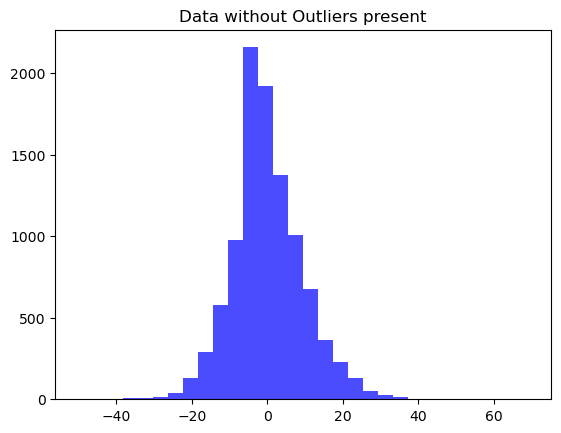

In [23]:
########## Training Dataset ##########
prop_corrupt = 0.1
n_train, n_val = 10000, 10000
Uniform = dist.Uniform(-3, 3)
X_train = Uniform.sample(sample_shape = [n_train, 3])

F1 = (0.8 * X_train[:,0])**3
F2 = 5 * np.sin(X_train[:,1])
F3 = 2 * np.cos(X_train[:,2])

S1 = torch.ones(n_train)
S2 = X_train[:,1] * 3
S3 = X_train[:,2]**2

y_train = F1 + F2 + F3 + torch.normal(torch.zeros(n_train), std = F.softplus(S1 + S2 + S3))
y_train = y_train.view(n_train, 1)

plt.hist(y_train.detach().numpy(), bins = 30, color = "blue", alpha = 0.7)
plt.title("Data without Outliers present")
plt.show()

########## Validation Dataset ###########

X_val = Uniform.sample(sample_shape = [n_val, 3])

F1_val = (0.8 * X_val[:,0])**3
F2_val = 5 * np.sin(X_val[:,1])
F3_val = 2 * np.cos(X_val[:,2])

S1_val = torch.ones(n_val)
S2_val = X_val[:,1] * 3
S3_val = X_val[:,2]**2

y_val = F1_val + F2_val + F3_val + torch.normal(torch.zeros(n_val), std = F.softplus(S1_val + S2_val + S3_val))
y_val = y_val.view(n_val, 1)

########## Testing Dataset ##########
n_test = 5000
X_test = Uniform.sample(sample_shape = [n_test, 3])

F1_test = (0.8 * X_test[:,0])**3
F2_test = 5 * np.sin(X_test[:,1])
F3_test = 2 * np.cos(X_test[:,2])

S1_test = torch.ones(n_test)
S2_test = X_test[:, 1] * 3
S3_test = X_test[:, 2] ** 2

y_test = F1_test + F2_test + F3_test + torch.normal(torch.zeros(n_test), std = F.softplus(S1_test + S2_test + S3_test))
y_test = y_test.view(n_test, 1)

### Sanity Check - Data without any outliers:

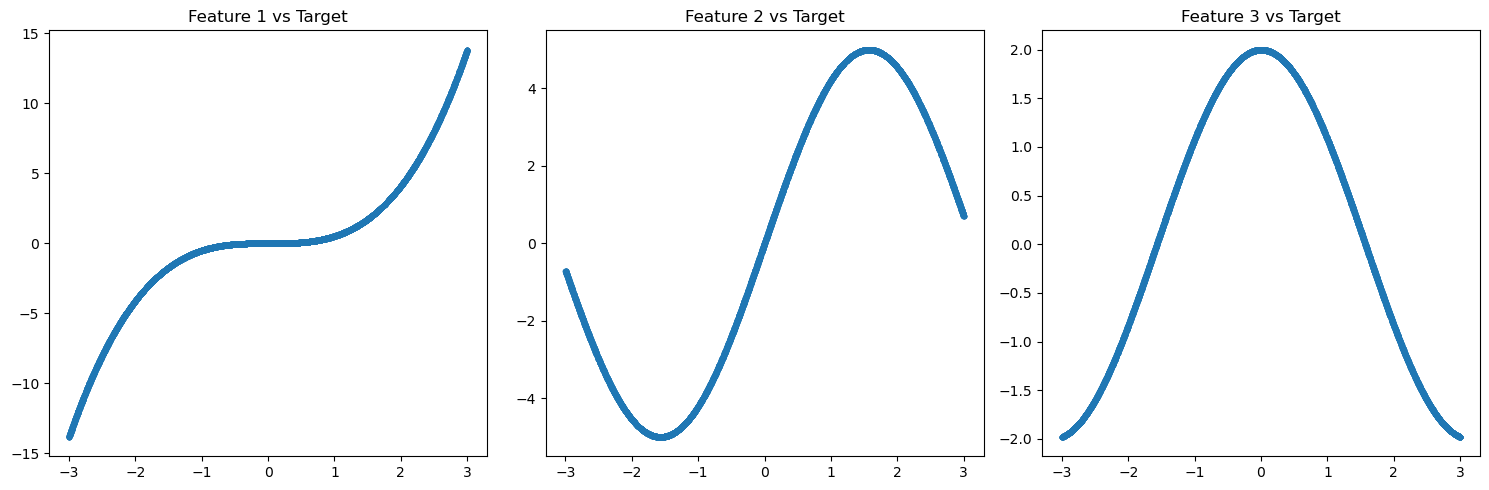

In [24]:
markersize = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot data in each subplot
axes[0].plot(X_train[:, 0], F1, "o", markersize = markersize)
axes[0].set_title("Feature 1 vs Target")

axes[1].plot(X_train[:, 1], F2, "o", markersize = markersize)
axes[1].set_title("Feature 2 vs Target")

axes[2].plot(X_train[:, 2], F3, "o", markersize = markersize)
axes[2].set_title("Feature 3 vs Target")

# Adjust layout for better appearance
plt.tight_layout()

# Show the figure
plt.show()

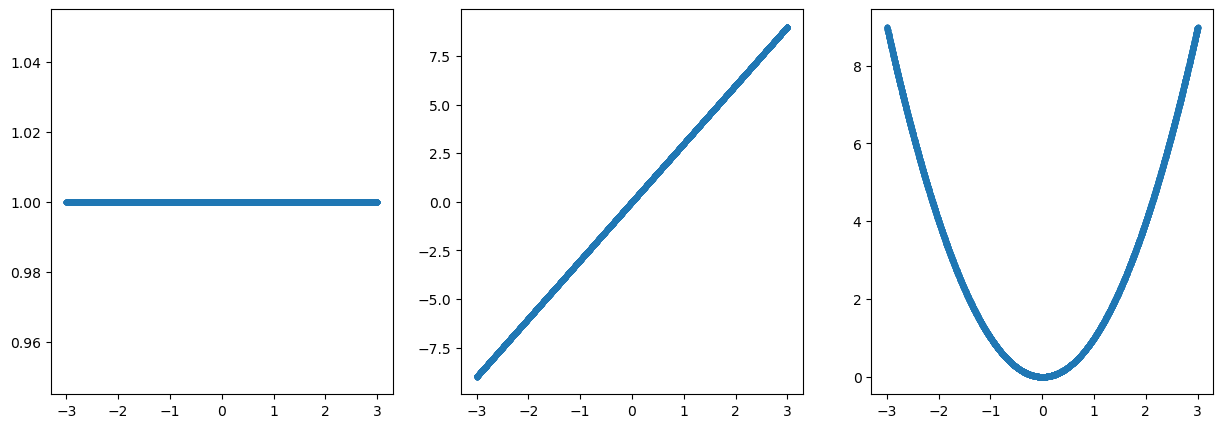

In [25]:
markersize = 3 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(X_train[:,0], S1, "o", markersize = markersize)
axes[1].plot(X_train[:,1], S2, "o", markersize = markersize)
axes[2].plot(X_train[:,2], S3, "o", markersize = markersize)
plt.show()

### Comparing a unregularized and robustified model on data without outliers:

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

In [27]:
scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

In [28]:
nam = NormalNAMLSS(3)
nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
mu, sigma = nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 1.7683 - Val Loss: 1.7620
Epoch 1 - Train Loss: 1.7643 - Val Loss: 1.7580
Epoch 2 - Train Loss: 1.7603 - Val Loss: 1.7541
Epoch 3 - Train Loss: 1.7563 - Val Loss: 1.7501
Epoch 4 - Train Loss: 1.7523 - Val Loss: 1.7462
Epoch 5 - Train Loss: 1.7484 - Val Loss: 1.7423
Epoch 6 - Train Loss: 1.7445 - Val Loss: 1.7385
Epoch 7 - Train Loss: 1.7406 - Val Loss: 1.7347
Epoch 8 - Train Loss: 1.7367 - Val Loss: 1.7308
Epoch 9 - Train Loss: 1.7329 - Val Loss: 1.7270
Epoch 10 - Train Loss: 1.7291 - Val Loss: 1.7233
Epoch 11 - Train Loss: 1.7253 - Val Loss: 1.7195
Epoch 12 - Train Loss: 1.7215 - Val Loss: 1.7158
Epoch 13 - Train Loss: 1.7177 - Val Loss: 1.7121
Epoch 14 - Train Loss: 1.7140 - Val Loss: 1.7084
Epoch 15 - Train Loss: 1.7102 - Val Loss: 1.7047
Epoch 16 - Train Loss: 1.7065 - Val Loss: 1.7011
Epoch 17 - Train Loss: 1.7028 - Val Loss: 1.6974
Epoch 18 - Train Loss: 1.6991 - Val Loss: 1.6938
Epoch 19 - Train Loss: 1.6955 - Val Loss: 1.6902
Epoch 20 - Train Loss: 1.6918 

In [29]:
robust_nam = NormalNAMLSS(3)
robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))
rob_mu, rob_sigma = robust_nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 1.5997 - Val Loss: 1.5954
Epoch 1 - Train Loss: 1.5967 - Val Loss: 1.5924
Epoch 2 - Train Loss: 1.5937 - Val Loss: 1.5895
Epoch 3 - Train Loss: 1.5907 - Val Loss: 1.5865
Epoch 4 - Train Loss: 1.5877 - Val Loss: 1.5836
Epoch 5 - Train Loss: 1.5848 - Val Loss: 1.5807
Epoch 6 - Train Loss: 1.5818 - Val Loss: 1.5777
Epoch 7 - Train Loss: 1.5788 - Val Loss: 1.5748
Epoch 8 - Train Loss: 1.5758 - Val Loss: 1.5718
Epoch 9 - Train Loss: 1.5729 - Val Loss: 1.5689
Epoch 10 - Train Loss: 1.5699 - Val Loss: 1.5660
Epoch 11 - Train Loss: 1.5669 - Val Loss: 1.5630
Epoch 12 - Train Loss: 1.5639 - Val Loss: 1.5601
Epoch 13 - Train Loss: 1.5609 - Val Loss: 1.5571
Epoch 14 - Train Loss: 1.5579 - Val Loss: 1.5541
Epoch 15 - Train Loss: 1.5549 - Val Loss: 1.5511
Epoch 16 - Train Loss: 1.5519 - Val Loss: 1.5482
Epoch 17 - Train Loss: 1.5489 - Val Loss: 1.5452
Epoch 18 - Train Loss: 1.5459 - Val Loss: 1.5422
Epoch 19 - Train Loss: 1.5429 - Val Loss: 1.5392
Epoch 20 - Train Loss: 1.5399 

In [30]:
strict_nam = NormalNAMLSS(3)
strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))
strict_mu, strict_sigma = strict_nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 0.9588 - Val Loss: 0.9575
Epoch 1 - Train Loss: 0.9573 - Val Loss: 0.9560
Epoch 2 - Train Loss: 0.9557 - Val Loss: 0.9544
Epoch 3 - Train Loss: 0.9542 - Val Loss: 0.9529
Epoch 4 - Train Loss: 0.9526 - Val Loss: 0.9513
Epoch 5 - Train Loss: 0.9511 - Val Loss: 0.9498
Epoch 6 - Train Loss: 0.9495 - Val Loss: 0.9482
Epoch 7 - Train Loss: 0.9479 - Val Loss: 0.9466
Epoch 8 - Train Loss: 0.9464 - Val Loss: 0.9451
Epoch 9 - Train Loss: 0.9448 - Val Loss: 0.9435
Epoch 10 - Train Loss: 0.9432 - Val Loss: 0.9419
Epoch 11 - Train Loss: 0.9417 - Val Loss: 0.9404
Epoch 12 - Train Loss: 0.9401 - Val Loss: 0.9388
Epoch 13 - Train Loss: 0.9385 - Val Loss: 0.9372
Epoch 14 - Train Loss: 0.9369 - Val Loss: 0.9356
Epoch 15 - Train Loss: 0.9353 - Val Loss: 0.9340
Epoch 16 - Train Loss: 0.9337 - Val Loss: 0.9324
Epoch 17 - Train Loss: 0.9321 - Val Loss: 0.9308
Epoch 18 - Train Loss: 0.9305 - Val Loss: 0.9292
Epoch 19 - Train Loss: 0.9289 - Val Loss: 0.9276
Epoch 20 - Train Loss: 0.9273 

### Clean Dataset - Mean Estimation

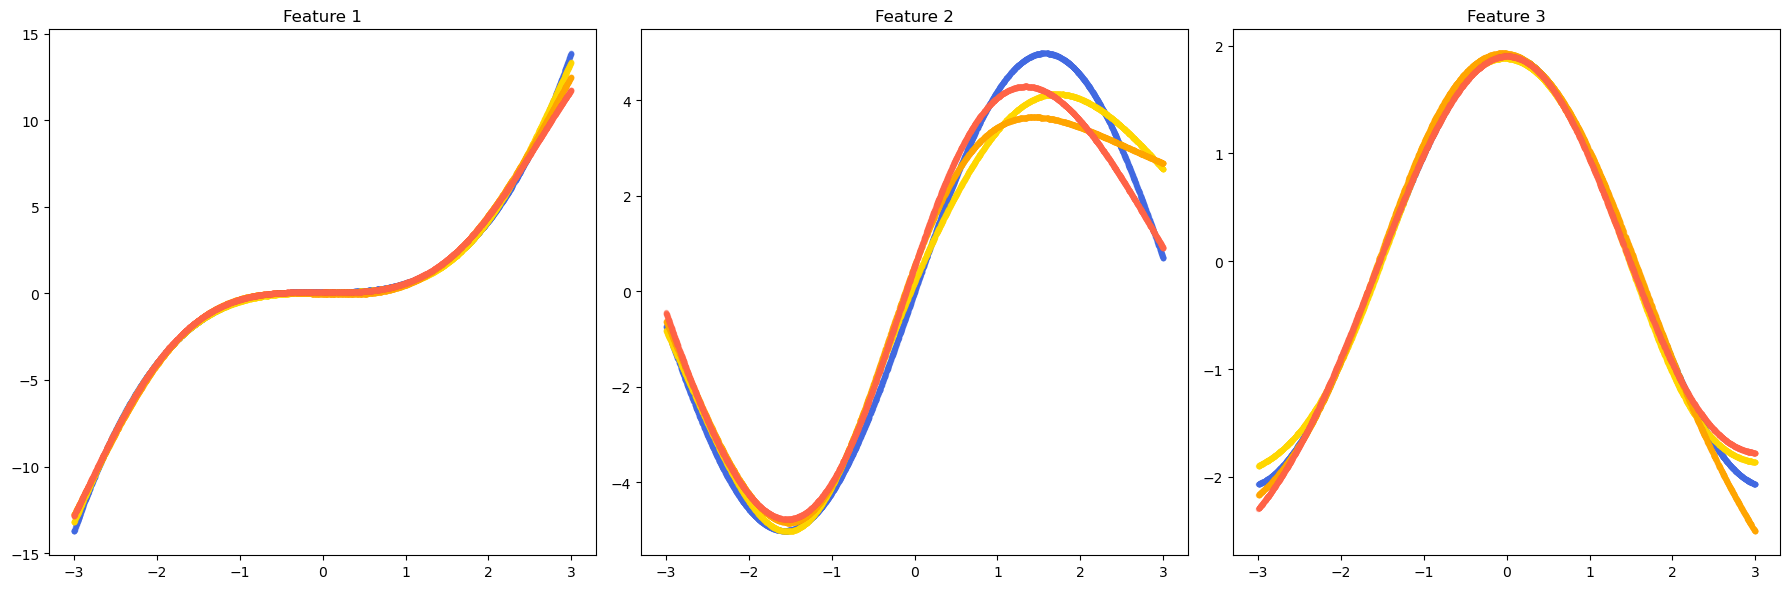

In [31]:
# Configuration
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

########## Marginal Effect Plots ##########
mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

########## Rescaling the values ##########
mu_components = mu_components * scaler3.scale_ + scaler3.mean_
robust_mu_components = robust_mu_components * scaler3.scale_ + scaler3.mean_
strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 1
axes[0].plot(X_test[:, 0], F1_test - F1_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[0].plot(X_test[:, 0], mu_components[:, 0] - mu_components[:, 0].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[0].plot(X_test[:, 0], robust_mu_components[:, 0] - robust_mu_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_mu_components[:, 0] - strict_mu_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], F2_test - F2_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[1].plot(X_test[:, 1], mu_components[:, 1] - mu_components[:, 1].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[1].plot(X_test[:, 1], robust_mu_components[:, 1] - robust_mu_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_mu_components[:, 1] - strict_mu_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 3
axes[2].plot(X_test[:, 2], F3_test - F3_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[2].plot(X_test[:, 2], mu_components[:, 2] - mu_components[:, 2].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[2].plot(X_test[:, 2], robust_mu_components[:, 2] - robust_mu_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_mu_components[:, 2] - strict_mu_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Clean Dataset - Sigma Estimation

In [32]:
sigma_components = sigma_components * scaler3.scale_
robust_sigma_components = robust_sigma_components * scaler3.scale_
strict_sigma_components = strict_sigma_components * scaler3.scale_

sigma_components = utils.inv_softplus(sigma_components)
robust_sigma_components = utils.inv_softplus(robust_sigma_components)
strict_sigma_components = utils.inv_softplus(strict_sigma_components)

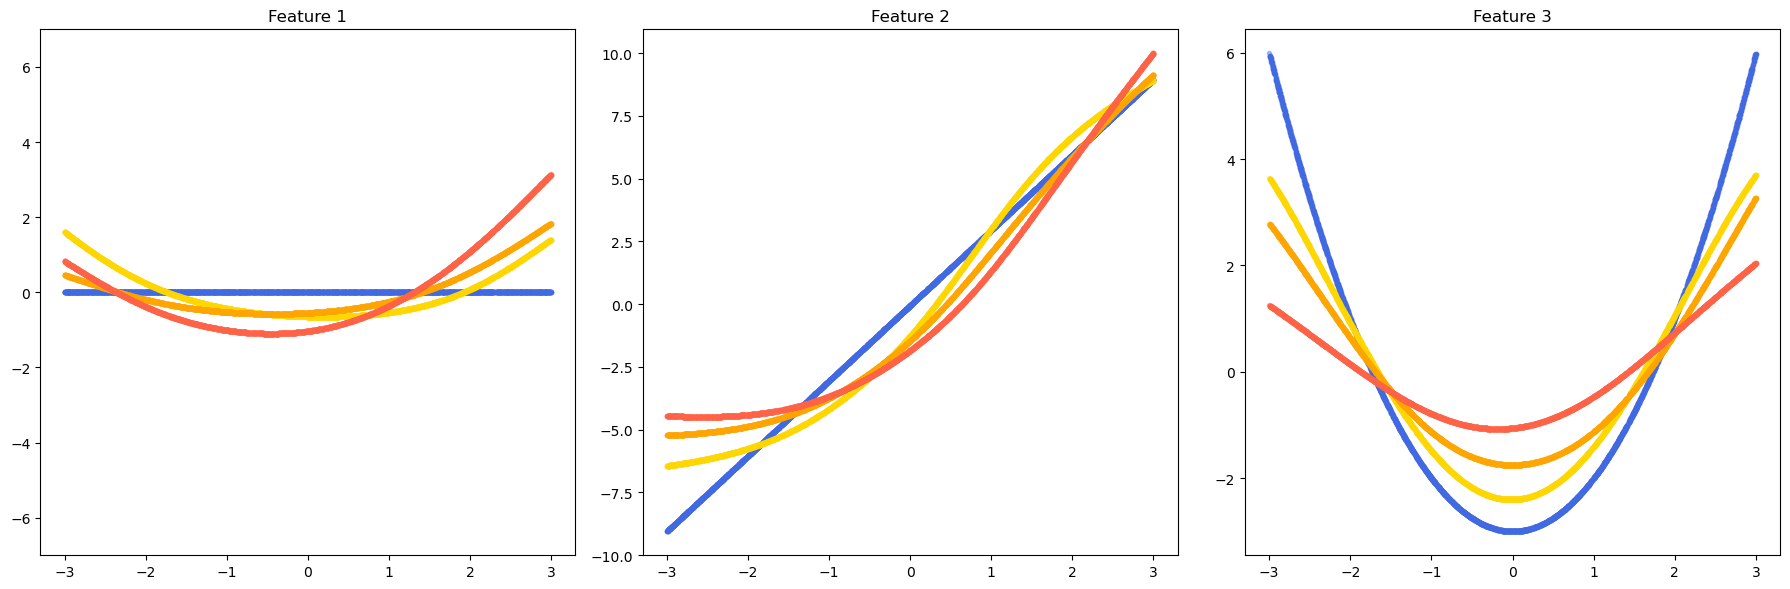

In [33]:
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 2
axes[0].plot(X_test[:, 0], S1_test - S1_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[0].plot(X_test[:, 0], sigma_components[:, 0] - sigma_components[:, 0].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[0].plot(X_test[:, 0], robust_sigma_components[:, 0] - robust_sigma_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_sigma_components[:, 0] - strict_sigma_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_ylim([-7,7])
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], S2_test - S2_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[1].plot(X_test[:, 1], sigma_components[:, 1] - sigma_components[:, 1].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[1].plot(X_test[:, 1], robust_sigma_components[:, 1] - robust_sigma_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_sigma_components[:, 1] - strict_sigma_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 2
axes[2].plot(X_test[:, 2], S3_test - S3_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[2].plot(X_test[:, 2], sigma_components[:, 2] - sigma_components[:, 2].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[2].plot(X_test[:, 2], robust_sigma_components[:, 2] - robust_sigma_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_sigma_components[:, 2] - strict_sigma_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Corrupted Data Example

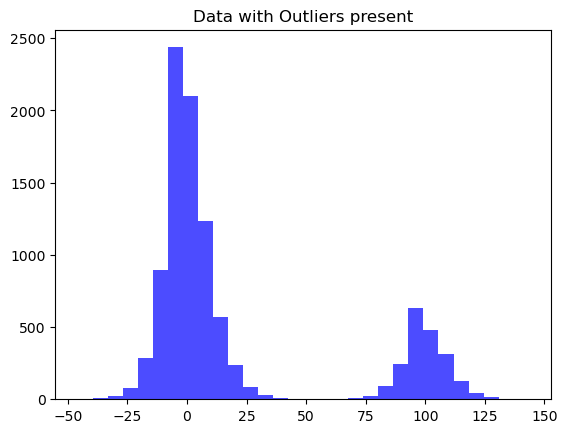

In [48]:
########## Training Dataset ##########
prop_corrupt = 0.2
n_train, n_val = 10000, 10000
BIAS = 100
Uniform = dist.Uniform(-3, 3)
X_train = Uniform.sample(sample_shape = [n_train, 3])

F1 = (0.8 * X_train[:,0])**3
F2 = 5 * np.sin(X_train[:,1])
F3 = 2 * np.cos(X_train[:,2])

S1 = torch.ones(n_train)
S2 = X_train[:,1] * 3
S3 = X_train[:,2]**2

y_train = F1 + F2 + F3 + torch.normal(torch.zeros(n_train), std = F.softplus(S1 + S2 + S3))
y_train = y_train.view(n_train, 1)

corrupted_indices = random.sample(range(1, n_train), int(n_train * prop_corrupt))
# sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
sign = torch.ones(size = (len(corrupted_indices),)).unsqueeze(1)
y_train[corrupted_indices] = y_train[corrupted_indices] + BIAS * sign

plt.hist(y_train.detach().numpy(), bins = 30, color = "blue", alpha = 0.7)
plt.title("Data with Outliers present")
plt.show()

########## Validation Dataset ###########

X_val = Uniform.sample(sample_shape = [n_val, 3])

F1_val = (0.8 * X_val[:,0])**3
F2_val = 5 * np.sin(X_val[:,1])
F3_val = 2 * np.cos(X_val[:,2])

S1_val = torch.ones(n_val)
S2_val = X_val[:,1] * 3
S3_val = X_val[:,2]**2

y_val = F1_val + F2_val + F3_val + torch.normal(torch.zeros(n_val), std = F.softplus(S1_val + S2_val + S3_val))
y_val = y_val.view(n_val, 1)

corrupted_indices = random.sample(range(1, n_val), int(n_val * prop_corrupt))
# sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
sign = torch.ones(size = (len(corrupted_indices),)).unsqueeze(1)
y_val[corrupted_indices] = y_val[corrupted_indices] + BIAS * sign

########## Testing Dataset ##########
n_test = 5000
X_test = Uniform.sample(sample_shape = [n_test, 3])

F1_test = (0.8 * X_test[:,0])**3
F2_test = 5 * np.sin(X_test[:,1])
F3_test = 2 * np.cos(X_test[:,2])

S1_test = torch.ones(n_test)
S2_test = X_test[:, 1] * 3
S3_test = X_test[:, 2] ** 2

y_test = F1_test + F2_test + F3_test + torch.normal(torch.zeros(n_test), std = F.softplus(S1_test + S2_test + S3_test))
y_test = y_test.view(n_test, 1)

corrupted_indices = random.sample(range(1, n_test), int(n_test * prop_corrupt))
# sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
sign = torch.ones(size = (len(corrupted_indices),)).unsqueeze(1)
y_test[corrupted_indices] = y_test[corrupted_indices] + BIAS * sign

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

In [50]:
scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

In [51]:
nam = NormalNAMLSS(3)
nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
mu, sigma = nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 1.8178 - Val Loss: 1.8110
Epoch 1 - Train Loss: 1.8127 - Val Loss: 1.8060
Epoch 2 - Train Loss: 1.8076 - Val Loss: 1.8009
Epoch 3 - Train Loss: 1.8026 - Val Loss: 1.7959
Epoch 4 - Train Loss: 1.7976 - Val Loss: 1.7909
Epoch 5 - Train Loss: 1.7926 - Val Loss: 1.7860
Epoch 6 - Train Loss: 1.7876 - Val Loss: 1.7811
Epoch 7 - Train Loss: 1.7827 - Val Loss: 1.7762
Epoch 8 - Train Loss: 1.7778 - Val Loss: 1.7714
Epoch 9 - Train Loss: 1.7730 - Val Loss: 1.7666
Epoch 10 - Train Loss: 1.7682 - Val Loss: 1.7618
Epoch 11 - Train Loss: 1.7634 - Val Loss: 1.7570
Epoch 12 - Train Loss: 1.7586 - Val Loss: 1.7523
Epoch 13 - Train Loss: 1.7539 - Val Loss: 1.7477
Epoch 14 - Train Loss: 1.7492 - Val Loss: 1.7430
Epoch 15 - Train Loss: 1.7446 - Val Loss: 1.7384
Epoch 16 - Train Loss: 1.7400 - Val Loss: 1.7339
Epoch 17 - Train Loss: 1.7354 - Val Loss: 1.7294
Epoch 18 - Train Loss: 1.7309 - Val Loss: 1.7249
Epoch 19 - Train Loss: 1.7264 - Val Loss: 1.7204
Epoch 20 - Train Loss: 1.7219 

In [52]:
robust_nam = NormalNAMLSS(3)
robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))
rob_mu, rob_sigma = robust_nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 1.6976 - Val Loss: 1.6949
Epoch 1 - Train Loss: 1.6951 - Val Loss: 1.6925
Epoch 2 - Train Loss: 1.6926 - Val Loss: 1.6900
Epoch 3 - Train Loss: 1.6901 - Val Loss: 1.6875
Epoch 4 - Train Loss: 1.6877 - Val Loss: 1.6850
Epoch 5 - Train Loss: 1.6852 - Val Loss: 1.6826
Epoch 6 - Train Loss: 1.6827 - Val Loss: 1.6801
Epoch 7 - Train Loss: 1.6802 - Val Loss: 1.6776
Epoch 8 - Train Loss: 1.6777 - Val Loss: 1.6751
Epoch 9 - Train Loss: 1.6752 - Val Loss: 1.6727
Epoch 10 - Train Loss: 1.6728 - Val Loss: 1.6702
Epoch 11 - Train Loss: 1.6703 - Val Loss: 1.6677
Epoch 12 - Train Loss: 1.6678 - Val Loss: 1.6652
Epoch 13 - Train Loss: 1.6653 - Val Loss: 1.6627
Epoch 14 - Train Loss: 1.6628 - Val Loss: 1.6602
Epoch 15 - Train Loss: 1.6603 - Val Loss: 1.6577
Epoch 16 - Train Loss: 1.6578 - Val Loss: 1.6553
Epoch 17 - Train Loss: 1.6553 - Val Loss: 1.6528
Epoch 18 - Train Loss: 1.6528 - Val Loss: 1.6503
Epoch 19 - Train Loss: 1.6503 - Val Loss: 1.6478
Epoch 20 - Train Loss: 1.6478 

In [53]:
strict_nam = NormalNAMLSS(3)
strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))
strict_mu, strict_sigma = strict_nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 0.9853 - Val Loss: 0.9847
Epoch 1 - Train Loss: 0.9842 - Val Loss: 0.9837
Epoch 2 - Train Loss: 0.9832 - Val Loss: 0.9826
Epoch 3 - Train Loss: 0.9821 - Val Loss: 0.9816
Epoch 4 - Train Loss: 0.9811 - Val Loss: 0.9805
Epoch 5 - Train Loss: 0.9800 - Val Loss: 0.9795
Epoch 6 - Train Loss: 0.9790 - Val Loss: 0.9784
Epoch 7 - Train Loss: 0.9779 - Val Loss: 0.9774
Epoch 8 - Train Loss: 0.9769 - Val Loss: 0.9763
Epoch 9 - Train Loss: 0.9758 - Val Loss: 0.9753
Epoch 10 - Train Loss: 0.9748 - Val Loss: 0.9742
Epoch 11 - Train Loss: 0.9737 - Val Loss: 0.9732
Epoch 12 - Train Loss: 0.9727 - Val Loss: 0.9721
Epoch 13 - Train Loss: 0.9716 - Val Loss: 0.9711
Epoch 14 - Train Loss: 0.9706 - Val Loss: 0.9700
Epoch 15 - Train Loss: 0.9695 - Val Loss: 0.9690
Epoch 16 - Train Loss: 0.9685 - Val Loss: 0.9679
Epoch 17 - Train Loss: 0.9674 - Val Loss: 0.9669
Epoch 18 - Train Loss: 0.9664 - Val Loss: 0.9658
Epoch 19 - Train Loss: 0.9653 - Val Loss: 0.9648
Epoch 20 - Train Loss: 0.9643 

### Corrupted Dataset - Mean Estimation

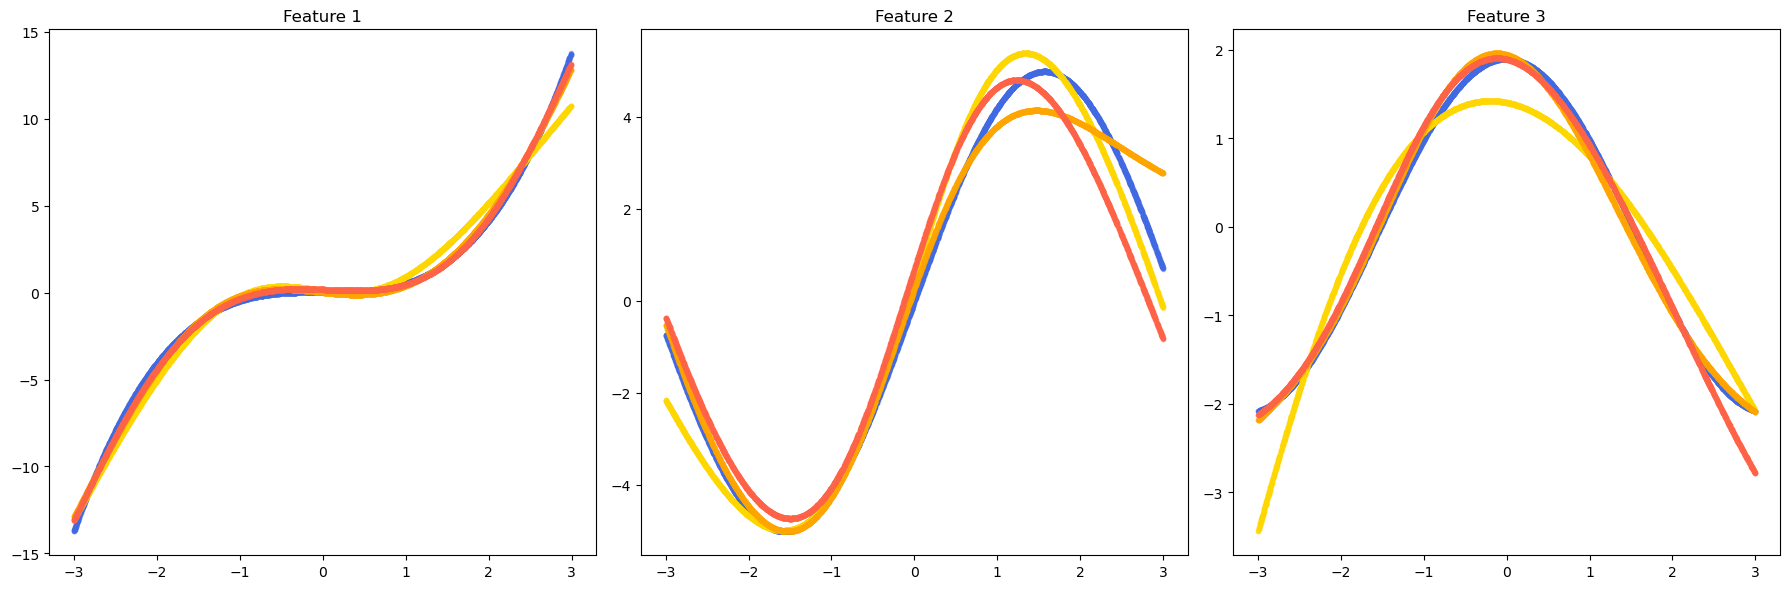

In [54]:
# Configuration
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

########## Marginal Effect Plots ##########
mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

########## Rescaling the values ##########
mu_components = mu_components * scaler3.scale_ + scaler3.mean_
robust_mu_components = robust_mu_components * scaler3.scale_ + scaler3.mean_
strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 1
axes[0].plot(X_test[:, 0], F1_test - F1_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[0].plot(X_test[:, 0], mu_components[:, 0] - mu_components[:, 0].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[0].plot(X_test[:, 0], robust_mu_components[:, 0] - robust_mu_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_mu_components[:, 0] - strict_mu_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], F2_test - F2_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[1].plot(X_test[:, 1], mu_components[:, 1] - mu_components[:, 1].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[1].plot(X_test[:, 1], robust_mu_components[:, 1] - robust_mu_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_mu_components[:, 1] - strict_mu_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 3
axes[2].plot(X_test[:, 2], F3_test - F3_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[2].plot(X_test[:, 2], mu_components[:, 2] - mu_components[:, 2].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[2].plot(X_test[:, 2], robust_mu_components[:, 2] - robust_mu_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_mu_components[:, 2] - strict_mu_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Corrupted Dataset - Sigma Estimation

In [55]:
sigma_components = sigma_components * scaler3.scale_
robust_sigma_components = robust_sigma_components * scaler3.scale_
strict_sigma_components = strict_sigma_components * scaler3.scale_

sigma_components = utils.inv_softplus(sigma_components)
robust_sigma_components = utils.inv_softplus(robust_sigma_components)
strict_sigma_components = utils.inv_softplus(strict_sigma_components)

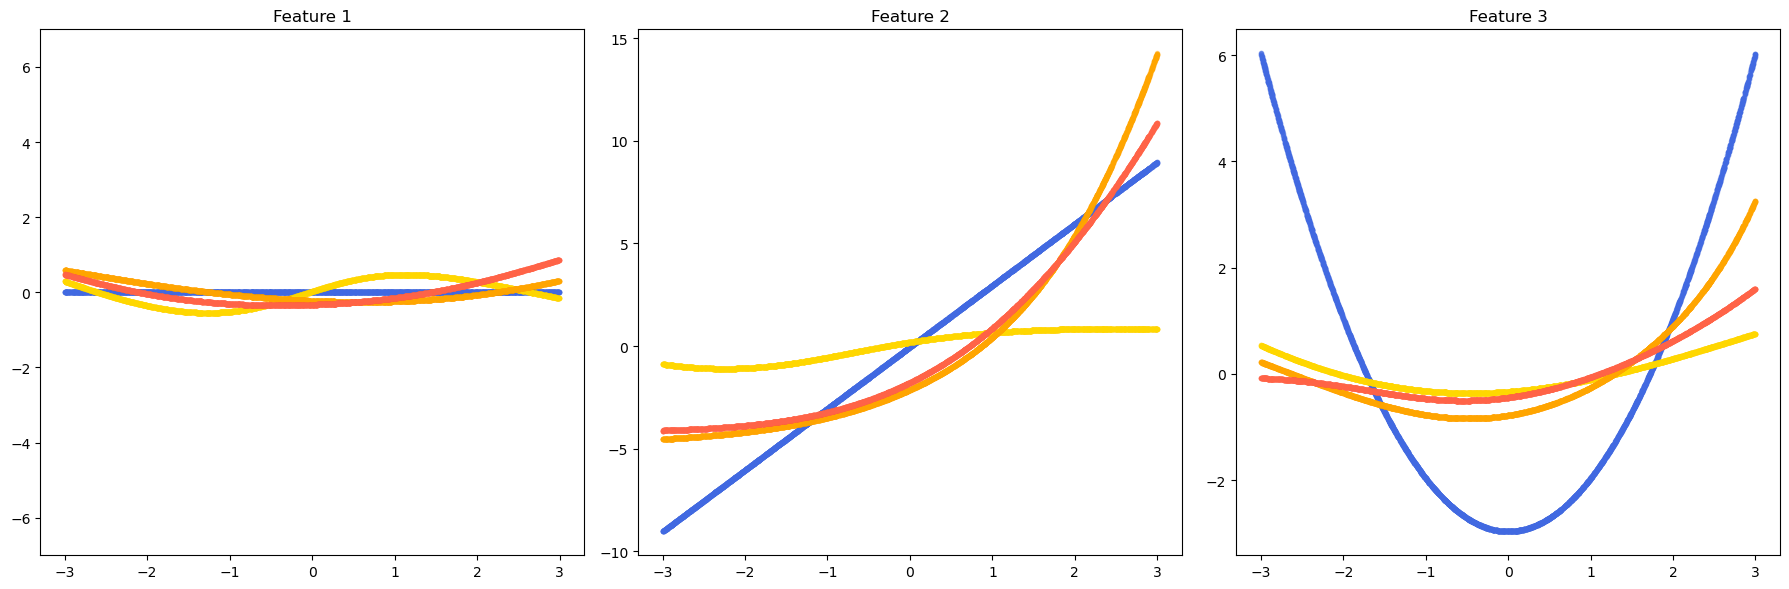

In [56]:
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 1
axes[0].plot(X_test[:, 0], S1_test - S1_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[0].plot(X_test[:, 0], sigma_components[:, 0] - sigma_components[:, 0].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[0].plot(X_test[:, 0], robust_sigma_components[:, 0] - robust_sigma_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_sigma_components[:, 0] - strict_sigma_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_ylim([-7,7])
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], S2_test - S2_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[1].plot(X_test[:, 1], sigma_components[:, 1] - sigma_components[:, 1].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[1].plot(X_test[:, 1], robust_sigma_components[:, 1] - robust_sigma_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_sigma_components[:, 1] - strict_sigma_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 3
axes[2].plot(X_test[:, 2], S3_test - S3_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[2].plot(X_test[:, 2], sigma_components[:, 2] - sigma_components[:, 2].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[2].plot(X_test[:, 2], robust_sigma_components[:, 2] - robust_sigma_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_sigma_components[:, 2] - strict_sigma_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Ideen:
- Extremere Kontaminierung
    - Variation des Korruptions-Anteils
    - Veränderung der Größenordnung
- Grad der Kontaminierung in Abhängigkeit von X variieren
    - Mehr Kontaminierung in bestimmten Wertebereichen
    - Variation der Outlier nach X
- Drittes Penalisiertes NN hinzufügen, um besser Trend zu erkennen
- Betrachtung von true y vs predicted y im test-set
- Getrennte Schätzung von Mu und Sigma
- Standardisierung von y
- Frage: Ist die generelle Prediction von y besser, wenn die Robustheits-Konstante dabei ist? (Histogramm, X-Y Plots)